In [1]:
from datetime import date, datetime, timedelta
from pathlib import Path
from tempfile import gettempdir

import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Data Download

- https://archive.ics.uci.edu/dataset/352/online+retail


In [36]:
def prepare_parquet_data():
    data_path = r"/home/anderson/Downloads/online-retail.xlsx"
    data = pd.read_excel(data_path)
    data = data[~data.CustomerID.isna()]
    data = data.astype(
        {
            "InvoiceNo": "string",
            "StockCode": "string",
            "Description": "string",
            "CustomerID": "int64",
            "Country": "string",
        }
    )
    data.to_parquet("./data/online-retail.parquet")


# prepare_parquet_data()
data = pd.read_parquet("./data/online-retail.parquet")
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


# Retention

- Cohort: 단순히 동일한 특성을 갖은 유저 그룹층을 말함. 


## Weekly Retention

In [51]:
from datetime import date, datetime, timedelta


def iso_year_start(iso_year):
    "The gregorian calendar date of the first day of the given ISO year"
    fourth_jan = date(iso_year, 1, 4)
    delta = timedelta(fourth_jan.isoweekday() - 1)
    return fourth_jan - delta


def iso_to_gregorian(iso_year, iso_week, iso_day):
    "Gregorian calendar date for the given ISO year, week and day"
    year_start = iso_year_start(iso_year)
    return year_start + timedelta(days=iso_day - 1, weeks=iso_week - 1)


def calculate_weekly_retention(data, costomer_col, date_col, use_unique_user=True):
    # CohortWeek: 기준이 되는 year + week of the year 사용
    # CohortFirstWeek: 해당 고객의 가장 처음 구매한 Invoice 날짜를 넣음.
    #                  transform 은 min(CohortWeek) OVER (PARTITOIN BY customer) 와 유사 -> 동일한 index shape 을 리턴
    # CohortIndex: 거래한 날짜 - 처음 거래한 날자 => 이렇게 하면 1주전, 2주전, 3주전, 4주전 등등 처럼 언제 구매했었는지 나타낼수 있다
    data["CohortWeek"] = data[date_col].apply(lambda x: iso_to_gregorian(x.year, x.week, 1))
    data["CohortFirstWeek"] = data.groupby(costomer_col).CohortWeek.transform("min")
    data["CohortIndex"] = (data.CohortWeek - data.CohortFirstWeek).dt.days
    
    if use_unique_user:
        retention = (
            data.groupby(["CohortFirstWeek", "CohortIndex"])
            [costomer_col].apply(pd.Series.nunique)
            .reset_index()
        )
    else:
        retention = (
            data.groupby(["CohortFirstWeek", "CohortIndex"])
            [costomer_col].count()
            .reset_index()
        )
    retention_count = retention.pivot_table(index="CohortFirstWeek", columns="CohortIndex", values=costomer_col)
    retention = retention_count.divide(retention_count.iloc[:, 0], axis=0).round(3)
    return retention_count, retention


retention_count, retention = calculate_weekly_retention(
    data, costomer_col="CustomerID", date_col="InvoiceDate", use_unique_user=False
)

display(retention.iloc[-10:, :10])
display(retention_count.iloc[-10:, :10])

CohortIndex,0,7,14,21,28,35,42,49,56,63
CohortFirstWeek,,,,,,,,,,
2011-10-03,1.0,0.122,0.015,0.020,0.046,0.083,0.082,0.060,0.080,0.025
2011-10-10,1.0,0.023,0.065,0.094,0.104,0.043,0.053,0.048,0.046,NaN
2011-10-17,1.0,0.035,0.099,0.097,0.069,0.023,0.101,0.092,NaN,NaN
2011-10-24,1.0,0.086,0.002,0.092,0.125,0.113,0.014,NaN,NaN,NaN
2011-10-31,1.0,0.016,0.043,0.055,0.061,0.044,NaN,NaN,NaN,NaN
2011-11-07,1.0,0.068,0.027,0.054,0.054,NaN,NaN,NaN,NaN,NaN
2011-11-14,1.0,0.014,0.079,0.032,NaN,NaN,NaN,NaN,NaN,NaN
2011-11-21,1.0,0.019,0.073,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-11-28,1.0,0.123,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


CohortIndex,0,7,14,21,28,35,42,49,56,63
CohortFirstWeek,,,,,,,,,,
2011-10-03,3095.0,377.0,45.0,63.0,143.0,257.0,253.0,185.0,247.0,77.0
2011-10-10,2437.0,57.0,158.0,230.0,253.0,106.0,128.0,117.0,111.0,NaN
2011-10-17,2487.0,86.0,245.0,240.0,171.0,56.0,252.0,230.0,NaN,NaN
2011-10-24,2575.0,221.0,5.0,238.0,322.0,291.0,35.0,NaN,NaN,NaN
2011-10-31,2679.0,43.0,116.0,148.0,164.0,118.0,NaN,NaN,NaN,NaN
2011-11-07,1905.0,129.0,51.0,102.0,102.0,NaN,NaN,NaN,NaN,NaN
2011-11-14,2534.0,36.0,201.0,81.0,NaN,NaN,NaN,NaN,NaN,NaN
2011-11-21,2436.0,46.0,179.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-11-28,1614.0,198.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Cohort Retention

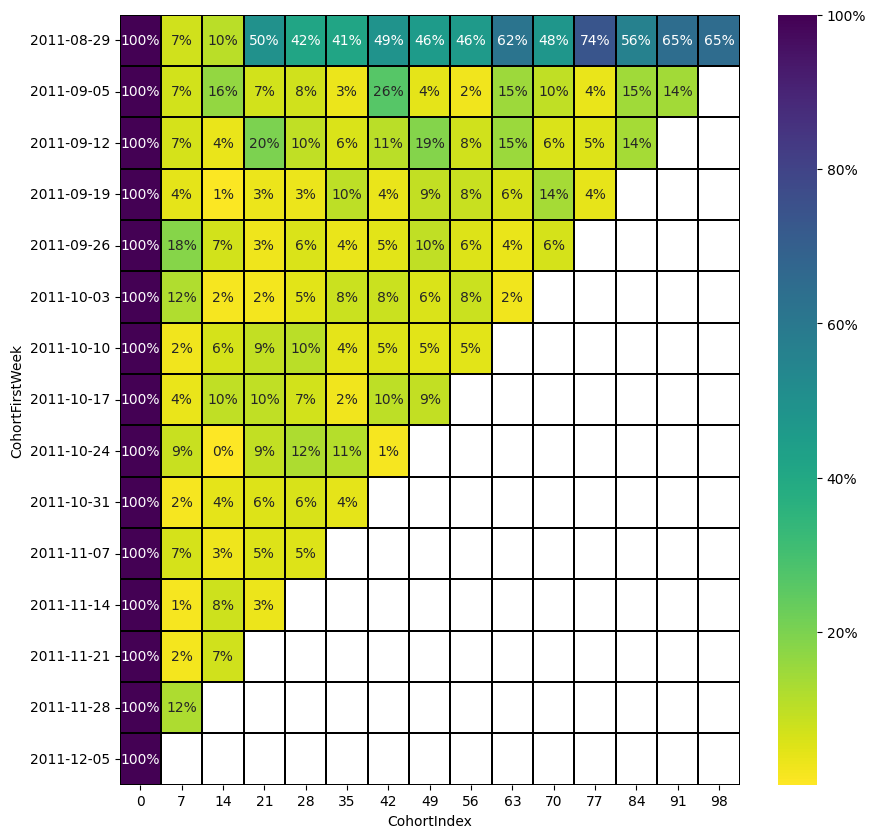

In [52]:
import matplotlib.ticker as ticker

plt.subplots(1, figsize=(10, 10))
ax = sns.heatmap(
    retention.iloc[-15:, :15],
    cmap="viridis_r",
    linewidths=0.2,
    linecolor="black",
    annot=True,
    fmt=".0%",
    cbar_kws={"format": ticker.FuncFormatter(lambda y, _: f"{y :0.0%}")},
)

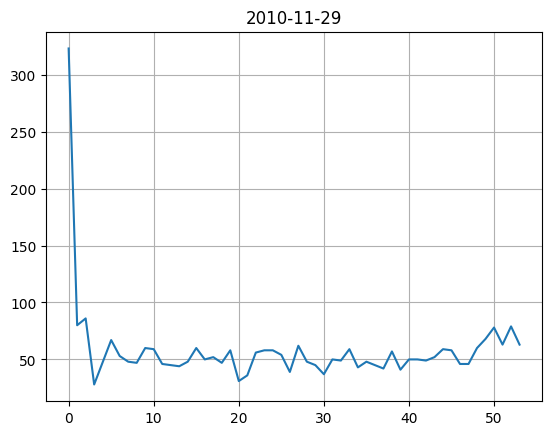

In [26]:
df = retention_count[pd.to_datetime(retention_count.index) == '2010-11-29']
ax = sns.lineplot(df.values.reshape(-1))
ax.set_title('2010-11-29')
ax.grid()

## Daily Retention

In [22]:
from datetime import date, datetime, timedelta

def calculate_daily_retention(data, costomer_col, date_col):
    data["CohortDay"] = data[date_col].apply(lambda x: x.date())
    data["CohortFirstDay"] = data.groupby(costomer_col).CohortDay.transform("min")
    data["CohortIndex"] = (data.CohortDay - data.CohortFirstDay).dt.days
    
    retention = (
        data.groupby(["CohortFirstDay", "CohortIndex"])
        .CustomerID.apply(pd.Series.nunique)
        .reset_index()
    )
    retention_count = retention.pivot_table(index="CohortFirstDay", columns="CohortIndex", values=costomer_col)
    retention = retention_count.divide(retention_count.iloc[:, 0], axis=0).round(3)
    return retention_count, retention


retention_count, retention = calculate_daily_retention(
    data, costomer_col="CustomerID", date_col="InvoiceDate"
)

display(retention.iloc[-10:, :10])
display(retention_count.iloc[-10:, :10])

CohortIndex,0,1,2,3,4,5,6,7,8,9
CohortFirstDay,,,,,,,,,,
2011-11-29,1.0,NaN,NaN,0.083,NaN,0.083,NaN,NaN,NaN,0.083
2011-11-30,1.0,0.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-12-01,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-12-02,1.0,NaN,NaN,NaN,NaN,NaN,0.143,NaN,NaN,NaN
2011-12-04,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-12-05,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-12-06,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-12-07,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-12-08,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


CohortIndex,0,1,2,3,4,5,6,7,8,9
CohortFirstDay,,,,,,,,,,
2011-11-29,12.0,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,1.0
2011-11-30,5.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-12-01,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-12-02,7.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
2011-12-04,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-12-05,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-12-06,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-12-07,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-12-08,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
def calculate_daily_retention(data, costomer_col, date_col):
    data["CohortDay"] = data[date_col].apply(lambda x: x.date())
    data["CohortFirstDay"] = data.groupby(costomer_col).CohortDay.transform("min")
    data["CohortIndex"] = (data.CohortDay - data.CohortFirstDay).dt.days
    
    retention = (
        data.groupby(["CohortFirstDay", "CohortIndex"])
        [costomer_col].apply(pd.Series.nunique)
        .reset_index()
    )
    retention_count = retention.pivot_table(index="CohortFirstDay", columns="CohortIndex", values=costomer_col)
    retention = retention_count.divide(retention_count.iloc[:, 0], axis=0).round(3)
    return retention_count, retention


retention_count, retention = calculate_daily_retention(
    data, costomer_col="Country", date_col="InvoiceDate"
)

IntCastingNaNError: Cannot convert non-finite values (NA or inf) to integer

In [33]:
retention_count

CohortIndex,0,1,2,3,4,5,6,7,8,9,...,364,365,366,367,368,369,370,371,372,373
CohortFirstDay,,,,,,,,,,,,,,,,,,,,,
2010-12-01,7.0,3.0,4.0,NaN,3.0,3.0,3.0,5.0,4.0,4.0,...,6.0,4.0,3.0,NaN,4.0,5.0,3.0,5.0,5.0,4.0
2010-12-03,6.0,NaN,NaN,2.0,NaN,1.0,2.0,1.0,NaN,NaN,...,2.0,NaN,NaN,1.0,4.0,2.0,NaN,1.0,NaN,NaN
2010-12-05,2.0,NaN,NaN,1.0,1.0,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-12-07,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-12-09,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-12-14,2.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-12-15,2.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-12-16,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-24,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
